In [6]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from google.colab import files
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.metrics import Recall,AUC
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d phylake1337/fire-dataset
!unzip fire-dataset.zip

 97% 377M/387M [00:03<00:00, 146MB/s]
100% 387M/387M [00:03<00:00, 109MB/s]
Archive:  fire-dataset.zip
  inflating: fire_dataset/fire_images/fire.1.png  
  inflating: fire_dataset/fire_images/fire.10.png  
  inflating: fire_dataset/fire_images/fire.100.png  
  inflating: fire_dataset/fire_images/fire.101.png  
  inflating: fire_dataset/fire_images/fire.102.png  
  inflating: fire_dataset/fire_images/fire.103.png  
  inflating: fire_dataset/fire_images/fire.104.png  
  inflating: fire_dataset/fire_images/fire.105.png  
  inflating: fire_dataset/fire_images/fire.106.png  
  inflating: fire_dataset/fire_images/fire.107.png  
  inflating: fire_dataset/fire_images/fire.108.png  
  inflating: fire_dataset/fire_images/fire.109.png  
  inflating: fire_dataset/fire_images/fire.11.png  
  inflating: fire_dataset/fire_images/fire.110.png  
  inflating: fire_dataset/fire_images/fire.111.png  
  inflating: fire_dataset/fire_images/fire.112.png  
  inflating: fire_dataset/fire_images/fire.113.png  


In [4]:
#create an empty DataFrame
df = pd.DataFrame(columns=['path','label'])

#loop over fire images and label them 1
for dirname, _, filenames in os.walk('/content/fire_dataset/fire_images'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))

#loop over non fire images and label them 0
for dirname, _, filenames in os.walk('/content/fire_dataset/non_fire_images'):
    for filename in filenames:
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label']))
        #print(os.path.join(dirname, filename))

#shuffle the dataset for redistribute the labels
df = df.sample(frac=1).reset_index(drop=True)
#df.head(10)

<ipython-input-4-e79775c4b10e>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))
<ipython-input-4-e79775c4b10e>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))
<ipython-input-4-e79775c4b10e>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))
<ipython-input-4-e79775c4b10e>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[

In [7]:
def shaper(row):
    shape = image.load_img(row['path']).size
    row['height'] = shape[1]
    row['width'] = shape[0]
    return row
df = df.apply(shaper,axis=1)
df.head(5)

,path,label,height,width
0,/content/fire_dataset/fire_images/fire.359.png,fire,843,1500
1,/content/fire_dataset/fire_images/fire.674.png,fire,490,653
2,/content/fire_dataset/fire_images/fire.735.png,fire,404,647
3,/content/fire_dataset/fire_images/fire.478.png,fire,414,992
4,/content/fire_dataset/non_fire_images/non_fire...,non_fire,579,950


In [8]:
generator = ImageDataGenerator(
    rotation_range= 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 2,
    zoom_range=0.2,
    rescale = 1/255,
    validation_split=0.2,
)

In [9]:
train_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='training')
val_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='validation')

Found 800 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.


In [10]:
class_indices = {}
for key in train_gen.class_indices.keys():
    class_indices[train_gen.class_indices[key]] = key

print(class_indices)

{0: 'fire', 1: 'non_fire'}


In [11]:
model = Sequential()
model.add(Conv2D(filters=32,kernel_size = (2,2),activation='relu',input_shape = (256,256,3)))
model.add(MaxPool2D())
model.add(Conv2D(filters=64,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(filters=128,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 255, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 64)      8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 63, 63, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 31, 31, 128)       0

In [13]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',Recall(),AUC()])

In [14]:
early_stoppping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5)

In [15]:
model.fit(x=train_gen,batch_size=32,epochs=5,validation_data=val_gen,callbacks=[early_stoppping,reduce_lr_on_plateau])

Epoch 1/5
25/25 [==============================] - 117s 5s/step - loss: 0.6116 - accuracy: 0.8100 - recall: 0.3187 - auc: 0.7638 - val_loss: 0.2890 - val_accuracy: 0.8894 - val_recall: 0.6452 - val_auc: 0.9756 - lr: 0.0010
Epoch 2/5
25/25 [==============================] - 106s 4s/step - loss: 0.1619 - accuracy: 0.9388 - recall: 0.8132 - auc: 0.9751 - val_loss: 0.1102 - val_accuracy: 0.9548 - val_recall: 0.9032 - val_auc: 0.9919 - lr: 0.0010
Epoch 3/5
25/25 [==============================] - 112s 4s/step - loss: 0.1263 - accuracy: 0.9450 - recall: 0.8462 - auc: 0.9860 - val_loss: 0.1331 - val_accuracy: 0.9548 - val_recall: 0.8548 - val_auc: 0.9911 - lr: 0.0010
Epoch 4/5
25/25 [==============================] - 103s 4s/step - loss: 0.1015 - accuracy: 0.9613 - recall: 0.9121 - auc: 0.9901 - val_loss: 0.1023 - val_accuracy: 0.9698 - val_recall: 0.9194 - val_auc: 0.9948 - lr: 0.0010
Epoch 5/5
25/25 [==============================] - 113s 5s/step - loss: 0.1139 - accuracy: 0.9538 - recall: 

In [23]:
model.save('fire-and-smoke-detection.h5')
files.download("fire-and-smoke-detection.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
eval_list = model.evaluate(val_gen,return_dict=True)
for metric in eval_list.keys():
    print(metric+f": {eval_list[metric]:.2f}")

7/7 [==============================] - 12s 2s/step - loss: 0.1195 - accuracy: 0.9548 - recall: 0.8871 - auc: 0.9922
loss: 0.12
accuracy: 0.95
recall: 0.89
auc: 0.99


In [20]:
import matplotlib.pyplot as plt

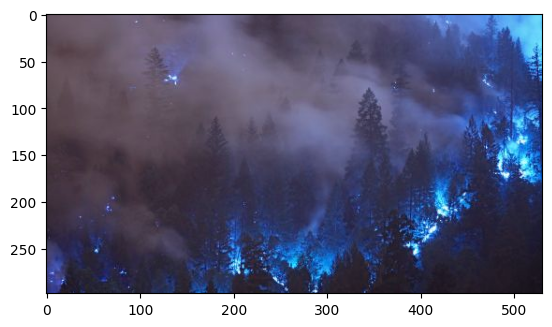

1/1 [==============================] - 0s 167ms/step
Fire


In [21]:
import cv2

test_img = cv2.imread("/content/fire_dataset/fire_images/fire.102.png")
plt.imshow(test_img)
plt.show()

test_img = cv2.resize(test_img,(256,256))
test_input = test_img.reshape((1,256,256,3))

res = model.predict(test_input)

if res[[0]] == 0. :
  print('Fire')
else:
  print('No Fire')

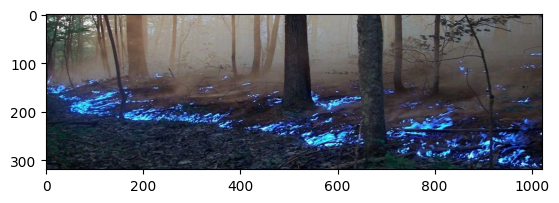

1/1 [==============================] - 0s 41ms/step
Fire


In [22]:
test_img = cv2.imread("/content/fire_dataset/fire_images/fire.11.png")
plt.imshow(test_img)
plt.show()

test_img = cv2.resize(test_img,(256,256))
test_input = test_img.reshape((1,256,256,3))

res = model.predict(test_input)

if res[[0]] == 0. :
  print('Fire')
else:
  print('No Fire')